## Introduction
Below Notebook is created as a Proof of concept for an idea that is to be presented in a Devpost Hackathon.

#### Summary
The summary of the idea is to create a system that will predict the future currency rates and suggest the user to buy or sell particular comodity in that currency rate.
The library that we have used to predict is called Prophet developed by Facebook.

#### Note
To run this notebook it is needed to install below libraries
1. pip install boto3
2. pip install requests-auth-aws-sigv4
3. pip install fbprophet
4. pip install chart-studio

In [3]:
# Importing necessary libraries
import requests
from requests_auth_aws_sigv4 import AWSSigV4
import json
import pandas as pd
from datetime import date, timedelta, datetime
from time import sleep
from time import time
from pandas import datetime
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters


# Libraries from fbprophet
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from chart_studio.plotly import plot, iplot
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import plot_cross_validation_metric

# Library form sklearn
from sklearn.model_selection import TimeSeriesSplit

# Libraries to supress warnings
import warnings
warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )
warnings.filterwarnings("ignore")

<ipython-input-3-5b984e69f4c1>:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


## Accessing AWS API

Below code is used to make the API request for AWS server, store the credentials in a json file and import that to access the database. Json structure should be as shown below,

{
    "asset-id": "Your-asset-id",
    "data-set-id": "Your-data-set-id",
    "revision-id": "Your-revision-id",
    "service": "interested-service",
    "aws_access_key_id": "Your-access-key-id",
    "aws_secret_access_key": "Your-secret-access-key"
}

In [85]:
# Opening JSON file
AWS_CONN = open('AWS_CONN.json')
aws_auth_data = json.load(AWS_CONN)

headers = {
    'Content-Type': 'application/json',
    'x-amzn-dataexchange-asset-id': aws_auth_data.get("asset-id"),
    'x-amzn-dataexchange-data-set-id': aws_auth_data.get("data-set-id"),
    'x-amzn-dataexchange-revision-id': aws_auth_data.get("revision-id")
    }

aws_auth = AWSSigV4(aws_auth_data.get("service"),
    aws_access_key_id = aws_auth_data.get("aws_access_key_id"),
    aws_secret_access_key = aws_auth_data.get("aws_secret_access_key"),
)
r = requests.request('GET', 'https://api-fulfill.dataexchange.us-east-1.amazonaws.com/v1/2020-11-24/currencies/usd.min.json' ,auth=aws_auth, headers=headers)

## Get Required Data

In [89]:
curr_list = requests.request('GET', 'https://api-fulfill.dataexchange.us-east-1.amazonaws.com/v1/currencies.json' ,auth=aws_auth, headers=headers)
curr_list_dict = json.loads(curr_list.text)
ccy_code_list = list(curr_list_dict.keys())

In [90]:
# Creating a list of dates relevent for data extraction
sdate = date(2020,11,22)   # start date
edate = date(2022,11,13)   # end date
date_list = pd.date_range(sdate,edate-timedelta(days=1),freq='d')

In [12]:
# Create a dataframe to store extracted data
ccy_rates = pd.DataFrame(columns=ccy_code_list)

In [106]:
i=0
for sing_date in date_list:
    date_str =str(sing_date)[0:10]
#     url = 'https://api-fulfill.dataexchange.us-east-1.amazonaws.com/v1/'+ date_str + '/currencies/usd.json'
#     get_rates = requests.request('GET', url ,auth=aws_auth, headers=headers)

    url = 'https://cdn.jsdelivr.net/gh/fawazahmed0/currency-api@1/'+ date_str + '/currencies/usd.min.json'
    get_rates = requests.request('GET', url)
    
    if get_rates.text[0:7] != 'Package':
        response_object = json.loads(get_rates.text)
        response_key_list = list(response_object.keys())
        if 'message' not in response_key_list:
            ccy_rates = ccy_rates.append(response_object['usd'], ignore_index=True)
            ccy_rates.at[i, 'Date']  = date_str
            i+=1
        


In [15]:
# Since extraction of data takes time we stored it into a CSV file which we use further
ccy_rates.to_csv('currency_rates.csv')

In [4]:
df_ccy_rates = pd.read_csv('currency_rates.csv')

## Data Visualisation
The idea is we have extracted the data for all the currencies with USD as base currency. So for example if the value for eur on date 12-11-2022 is 0.96 it means 1 USD = 0.96 EUR

Now lets visualise how the data trend is for Euros, Chinese Yuan, and Indian Rupees

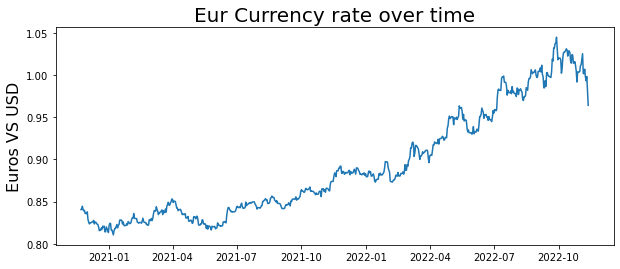

In [16]:
usd_eur = df_ccy_rates[['Date', 'eur']].copy()
usd_eur['Date'] = pd.to_datetime(usd_eur.Date)
usd_eur = usd_eur.rename(columns={'Date':'ds','eur':'y'})
plt.figure(figsize=(10,4))
plt.title('Eur Currency rate over time', fontsize=20)
plt.ylabel('Euros VS USD', fontsize=16)
plt.plot(usd_eur['ds'], usd_eur['y'])

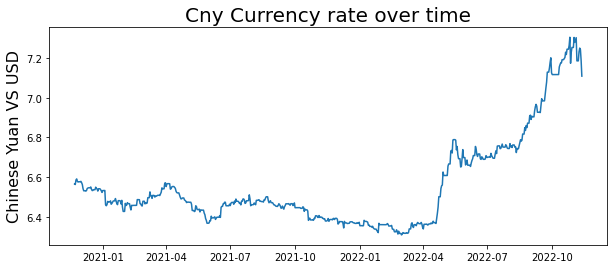

In [26]:
usd_cny = df_ccy_rates[['Date', 'cny']].copy()
usd_cny['Date'] = pd.to_datetime(usd_cny.Date)
usd_cny = usd_cny.rename(columns={'Date':'ds','cny':'y'})
plt.figure(figsize=(10,4))
plt.title('Cny Currency rate over time', fontsize=20)
plt.ylabel('Chinese Yuan VS USD', fontsize=16)
plt.plot(usd_cny['ds'], usd_cny['y'])

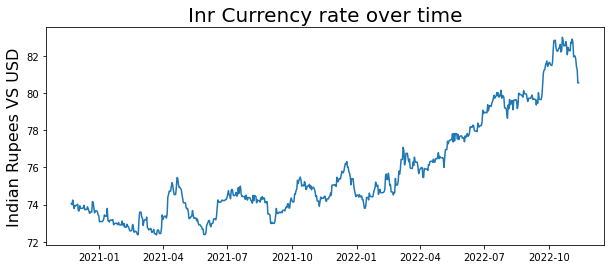

In [23]:
usd_inr = df_ccy_rates[['Date', 'inr']].copy()
usd_inr['Date'] = pd.to_datetime(usd_inr.Date)
usd_inr = usd_inr.rename(columns={'Date':'ds','inr':'y'})
plt.figure(figsize=(10,4))
plt.title('Inr Currency rate over time', fontsize=20)
plt.ylabel('Indian Rupees VS USD', fontsize=16)
plt.plot(usd_inr['ds'], usd_inr['y'])

Based on above graph we can see an upward trend with no particular seasonality, it can be clearly observed that the data is not stationary for all the three currencies

## Creating forecasting model for Euros

In [109]:
# Splitting data into training and testing
data_train = usd_eur[usd_eur['ds']<'2022-07-01']
data_test = usd_eur[usd_eur['ds']>='2022-07-01']

In [110]:
# Creating the model based on training data and visualising the future trend
model_usd_eur = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_usd_eur.fit(data_train)
future_days = model_usd_eur.make_future_dataframe(periods=68, freq='2D')

forecast_days = model_usd_eur.predict(future_days)
forecast_days['yhat'] = forecast_days['yhat'].clip(lower=0)

plot_plotly(model_usd_eur, forecast_days)


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


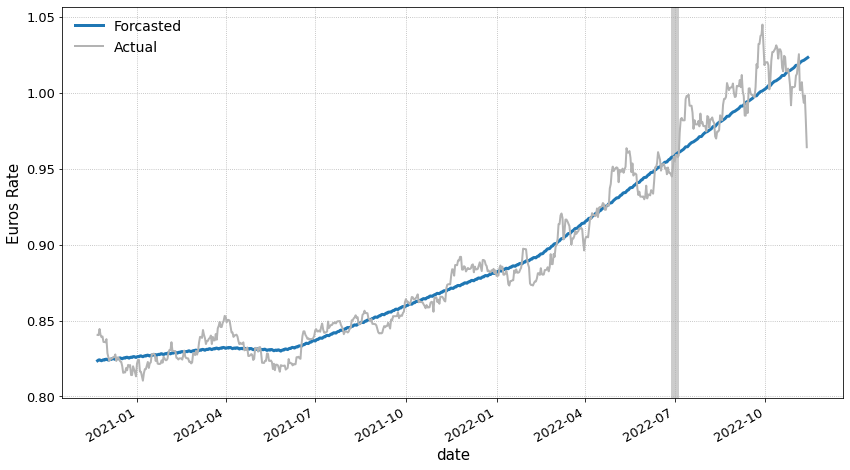

In [111]:
# Checking how well the data is fit
forecasted = forecast_days[["ds","yhat"]]
forecasted = forecasted.set_index('ds')

original = usd_eur.copy(deep=True)
original = original.set_index('ds')

f, ax = plt.subplots(figsize=(14,8))


forecasted.plot(ax=ax, ls='-', lw=3);
original.plot(ax=ax, ls='-', lw=2,color= '0.7');

ax.grid(ls=':')
ax.legend(['Forcasted','Actual'], frameon=False, fontsize=14);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('Euros Rate', fontsize=15);

ax.axvline('2022-07-01', color='0.8', lw=8, zorder=-1);

In [60]:
# Training the model using cross validation technique and calculating the performance metrics
cv_eur = cross_validation(model_usd_eur, initial='100 days', period='135 days', horizon = '50 days')
performance_cv_eur = performance_metrics(cv_eur)
performance_cv_eur.describe()

INFO:fbprophet:Making 4 forecasts with cutoffs between 2021-04-01 00:00:00 and 2022-05-11 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
count,46,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,27 days 12:00:00,0.000509,0.021420,0.018736,0.021800,0.019353,0.193650
std,13 days 10:08:34.171681971,0.000300,0.007136,0.006217,0.007416,0.007190,0.141760
min,5 days 00:00:00,0.000088,0.009364,0.008383,0.009598,0.008381,0.000000
25%,16 days 06:00:00,0.000232,0.015203,0.014336,0.016565,0.014436,0.052632
50%,27 days 12:00:00,0.000504,0.022454,0.020354,0.023714,0.019837,0.197368
75%,38 days 18:00:00,0.000656,0.025603,0.022725,0.026533,0.022787,0.332237
max,50 days 00:00:00,0.001058,0.032528,0.027468,0.032129,0.035659,0.473684


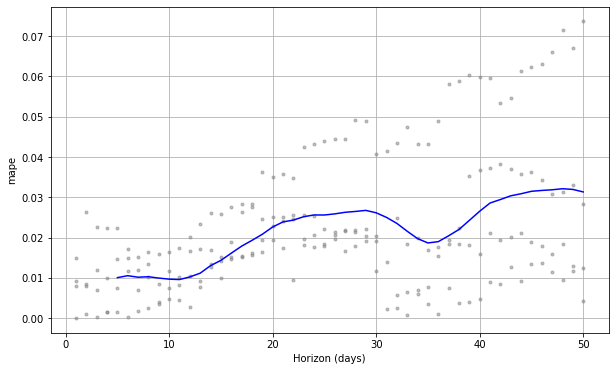

In [61]:
# Visualising the mean absolute percentage error
fig = plot_cross_validation_metric(cv_eur, metric='mape')

In [62]:
# Calculating the MAPE of the model

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

pred = model_usd_eur.predict(pd.DataFrame(data_test["ds"]))
pred['yhat'] = pred['yhat'].clip(lower = 1)
mean_absolute_percentage_error(data_test['y'],pred['yhat'])

1.538330615914659

Here the mean absolute percentage error is 1.53% which suggests that the model has high predective power and can be used to predict the future values

In [72]:
# Training the model on the complete dataframe to get the over all picture and then plotting it on some future dates
model_usd_eur_all = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_usd_eur_all.fit(usd_eur)
usd_eur_forecast = model_usd_eur_all.make_future_dataframe(periods=117, freq='2D')
usd_eur_future_data = usd_eur_forecast[usd_eur_forecast['ds']>'2022-11-12']
usd_eur_forcasted_data = model_usd_eur_all.predict(usd_eur_future_data) 
plot_plotly(model_usd_eur_all,usd_eur_forcasted_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


## Creating forecasting model for Chinese Yuan

In [114]:
# Splitting data into training and testing
data_train_cny = usd_cny[usd_cny['ds']<'2022-07-01']
data_test_cny = usd_cny[usd_cny['ds']>='2022-07-01']

In [115]:
# Creating the model based on training data and visualising the future trend
model_usd_cny = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_usd_cny.fit(data_train_cny)
future_days = model_usd_cny.make_future_dataframe(periods=68, freq='2D')

forecast_days = model_usd_cny.predict(future_days)
forecast_days['yhat'] = forecast_days['yhat'].clip(lower=0)

plot_plotly(model_usd_cny, forecast_days)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


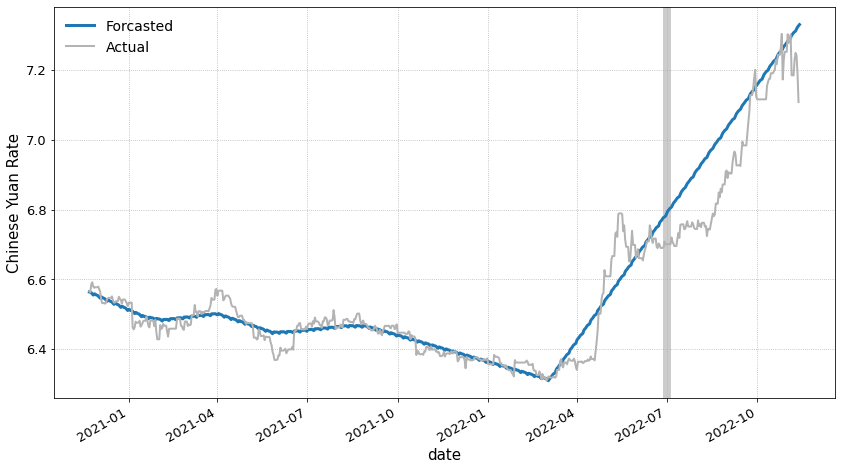

In [116]:
# Checking how well the data is fit
forecasted = forecast_days[["ds","yhat"]]
forecasted = forecasted.set_index('ds')

original = usd_cny.copy(deep=True)
original = original.set_index('ds')

f, ax = plt.subplots(figsize=(14,8))


forecasted.plot(ax=ax, ls='-', lw=3);
original.plot(ax=ax, ls='-', lw=2,color= '0.7');

ax.grid(ls=':')
ax.legend(['Forcasted','Actual'], frameon=False, fontsize=14);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('Chinese Yuan Rate', fontsize=15);

ax.axvline('2022-07-01', color='0.8', lw=8, zorder=-1);

In [69]:
# Training the model using cross validation technique and calculating the performance metrics
cv_cny = cross_validation(model_usd_cny, initial='100 days', period='135 days', horizon = '50 days')
performance_cv_cny = performance_metrics(cv_cny)
performance_cv_cny.describe()

INFO:fbprophet:Making 4 forecasts with cutoffs between 2021-04-01 00:00:00 and 2022-05-11 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
count,46,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,27 days 12:00:00,0.013471,0.114621,0.090685,0.013804,0.011183,0.247426
std,13 days 10:08:34.171681971,0.004218,0.018444,0.019267,0.003036,0.006511,0.218272
min,5 days 00:00:00,0.007552,0.086900,0.062214,0.009396,0.001414,0.000000
25%,16 days 06:00:00,0.009141,0.095611,0.077730,0.011811,0.005854,0.095395
50%,27 days 12:00:00,0.013602,0.116628,0.081301,0.012221,0.009724,0.236842
75%,38 days 18:00:00,0.017204,0.131163,0.113286,0.017377,0.017320,0.302632
max,50 days 00:00:00,0.021047,0.145077,0.119111,0.018335,0.022874,0.750000


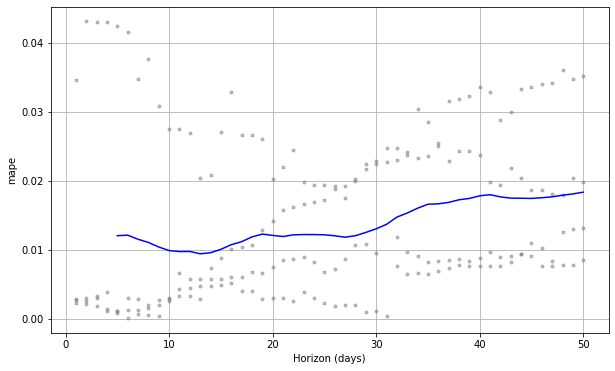

In [70]:
# Visualising the mean absolute percentage error
fig = plot_cross_validation_metric(cv_cny, metric='mape')

In [71]:
# Calculating the MAPE of the model
pred = model_usd_cny.predict(pd.DataFrame(data_test_cny["ds"]))
pred['yhat'] = pred['yhat'].clip(lower = 1)
mean_absolute_percentage_error(data_test_cny['y'],pred['yhat'])

1.5392235806136478

Here the mean absolute percentage error is 1.53% which suggests that the model has high predective power and can be used to predict the future values

In [74]:
# Training the model on the complete dataframe to get the over all picture and then plotting it on some future dates
model_usd_cny_all = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_usd_cny_all.fit(usd_cny)
usd_cny_forecast = model_usd_cny_all.make_future_dataframe(periods=117, freq='2D')
usd_cny_future_data = usd_cny_forecast[usd_cny_forecast['ds']>'2022-11-12']
usd_cny_forcasted_data = model_usd_cny_all.predict(usd_cny_future_data) 
plot_plotly(model_usd_cny_all,usd_cny_forcasted_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


## Creating forecasting model for Indian Rupees

In [117]:
# Splitting data into training and testing
data_train_inr = usd_inr[usd_inr['ds']<'2022-07-01']
data_test_inr = usd_inr[usd_inr['ds']>='2022-07-01']

In [118]:
# Creating the model based on training data and visualising the future trend
model_usd_inr = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_usd_inr.fit(data_train_inr)
future_days = model_usd_inr.make_future_dataframe(periods=68, freq='2D')

forecast_days = model_usd_inr.predict(future_days)
forecast_days['yhat'] = forecast_days['yhat'].clip(lower=0)

plot_plotly(model_usd_inr, forecast_days)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


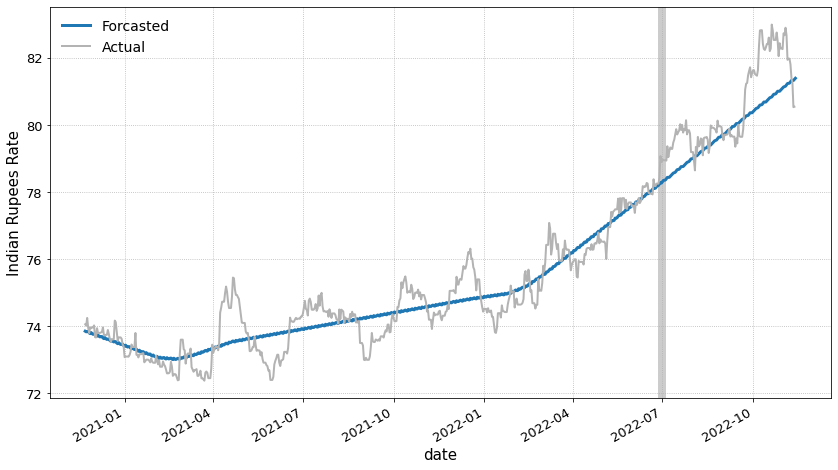

In [119]:
# Checking how well the data is fit
forecasted = forecast_days[["ds","yhat"]]
forecasted = forecasted.set_index('ds')

original = usd_inr.copy(deep=True)
original = original.set_index('ds')

f, ax = plt.subplots(figsize=(14,8))


forecasted.plot(ax=ax, ls='-', lw=3);
original.plot(ax=ax, ls='-', lw=2,color= '0.7');

ax.grid(ls=':')
ax.legend(['Forcasted','Actual'], frameon=False, fontsize=14);

[l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
[l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]

ax.set_xlabel('date', fontsize=15)

ax.set_ylabel('Indian Rupees Rate', fontsize=15);

ax.axvline('2022-07-01', color='0.8', lw=8, zorder=-1);

In [78]:
# Training the model using cross validation technique and calculating the performance metrics
cv_inr = cross_validation(model_usd_inr, initial='100 days', period='135 days', horizon = '50 days')
performance_cv_inr = performance_metrics(cv_inr)
performance_cv_inr.describe()

INFO:fbprophet:Making 4 forecasts with cutoffs between 2021-04-01 00:00:00 and 2022-05-11 00:00:00


  0%|          | 0/4 [00:00<?, ?it/s]

,horizon,mse,rmse,mae,mape,mdape,coverage
count,46,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,27 days 12:00:00,2.113995,1.427014,1.333847,0.017856,0.017787,0.154176
std,13 days 10:08:34.171681971,0.800223,0.281691,0.246109,0.003332,0.004291,0.076455
min,5 days 00:00:00,0.601042,0.775269,0.759184,0.010137,0.009620,0.000000
25%,16 days 06:00:00,1.663666,1.289819,1.222755,0.016317,0.014262,0.105263
50%,27 days 12:00:00,1.895775,1.376867,1.309287,0.017516,0.018127,0.157895
75%,38 days 18:00:00,2.721336,1.649604,1.525597,0.020450,0.020232,0.210526
max,50 days 00:00:00,3.648110,1.910003,1.738231,0.023334,0.027770,0.250000


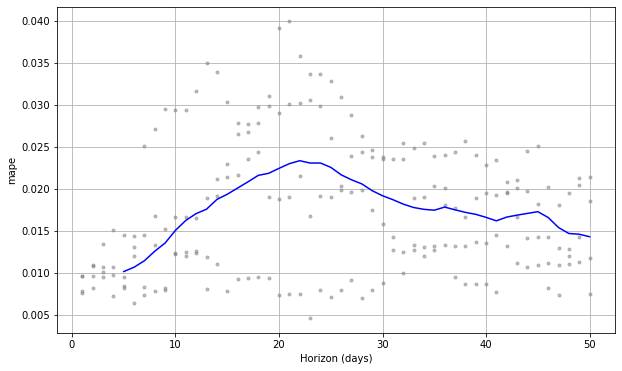

In [79]:
# Visualising the mean absolute percentage error
fig = plot_cross_validation_metric(cv_inr, metric='mape')

In [80]:
# Calculating the MAPE of the model
pred = model_usd_inr.predict(pd.DataFrame(data_test_inr["ds"]))
pred['yhat'] = pred['yhat'].clip(lower = 1)
mean_absolute_percentage_error(data_test_inr['y'],pred['yhat'])

1.0055434572973916

Here the mean absolute percentage error is 1.00% which suggests that the model has high predective power and can be used to predict the future values

In [81]:
# Training the model on the complete dataframe to get the over all picture and then plotting it on some future dates
model_usd_inr_all = Prophet(changepoint_prior_scale=0.01, seasonality_mode='multiplicative', \
            weekly_seasonality=True, \
            daily_seasonality=False)

model_usd_inr_all.fit(usd_inr)
usd_inr_forecast = model_usd_inr_all.make_future_dataframe(periods=117, freq='2D')
usd_inr_future_data = usd_inr_forecast[usd_inr_forecast['ds']>'2022-11-12']
usd_inr_forcasted_data = model_usd_inr_all.predict(usd_inr_future_data) 
plot_plotly(model_usd_inr_all,usd_inr_forcasted_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
